# Colab Link
<a href="https://colab.research.google.com/drive/1zZWuUgP-zF0yl_ySi4abJbjNTEEID0rm?usp=sharing"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Model Formalization

**Indices**  

time = $t$  
batteries = $b$  

**Variables**

power demanded(purchased) = $P^d_{tb}$ (kwh)  
power generated(sold) = $P^g_{tb}$ (kwh)     
capacity = $C$ (kwh)

**Parameters**  

spot price = $s_t$ (\\$/MWh)     
Max rate of charge = $R^c$ (kw)  
Max rate of discharge = $R^d$ (kw)  
Max Battery Capacity = $C^{max}$ (kwh)    
Min Battery Capacity = $C^{min}$ (kwh)  
Battery State = $C_t$ (kwh)    
daily discharge energy capacity = $d$ (kwh)   
round trip efficiency = $e$  (0 to 1)  
  - Round trip efficiency goes in the objective too?  

Number of time steps = $T$  
Number of batteries = $B$    

**Objective**  

$$
max \quad \sum_{t=1}^{T}\sum_{b=1}^{B} P^g_{tb}s_t - P^d_{tb}s_t  
$$

The objective is to maximize the profit of the operating batteries by summing up the costs and revenues across all time steps and batteries. 

**Constraints**  

$$
\begin{align}
    C^{min} \leq C_t \leq C^{max} \tag{1} \\
    C_t = C_{t-1} + eP^d_{tb} - P^g_{tb} \tag{2}\\
    0 \leq P^d_{tb} \leq R^c \tag{3}\\
    0 \leq P^g_{tb} \leq R^d \tag{4}\\
    \sum_{t=1}^{T} P^g_{bt} \leq d_b \quad \forall b \tag{5}
\end{align}
$$  

$1$: Sets the bounds of the battery state across all time steps.  
$2$: Sets the charge state of the battery across all t given net power differential and the previous charge state.  
$3$: Sets the bounds of the charge power for the battery.  
$4$: Sets the bounds of the discharge power for the battery.  
$5$: Sets the max energy that can be discharged in a day for a battery



## Model

In [2]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
df = pd.read_csv('data/20170801damlbmp_zone_csv/20170801damlbmp_zone.csv', index_col="Time Stamp")
df.head()

,Name,PTID,LBMP ($/MWHr),Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
Time Stamp,,,,,
08/01/2017 00:00,CAPITL,61757,20.38,1.24,0.0
08/01/2017 00:00,CENTRL,61754,19.31,0.17,0.0
08/01/2017 00:00,DUNWOD,61760,21.38,2.24,0.0
08/01/2017 00:00,GENESE,61753,18.99,-0.15,0.0
08/01/2017 00:00,H Q,61844,18.43,-0.71,0.0


In [4]:
nyc_df=df[df["Name"]=='N.Y.C.'][['LBMP ($/MWHr)']]
nyc_df.columns = ['cost']
nyc_df.head()

,cost
Time Stamp,
08/01/2017 00:00,21.65
08/01/2017 01:00,19.94
08/01/2017 02:00,18.48
08/01/2017 03:00,17.28
08/01/2017 04:00,18.00


Text(0, 0.5, 'LBMP ($/MWHr)')

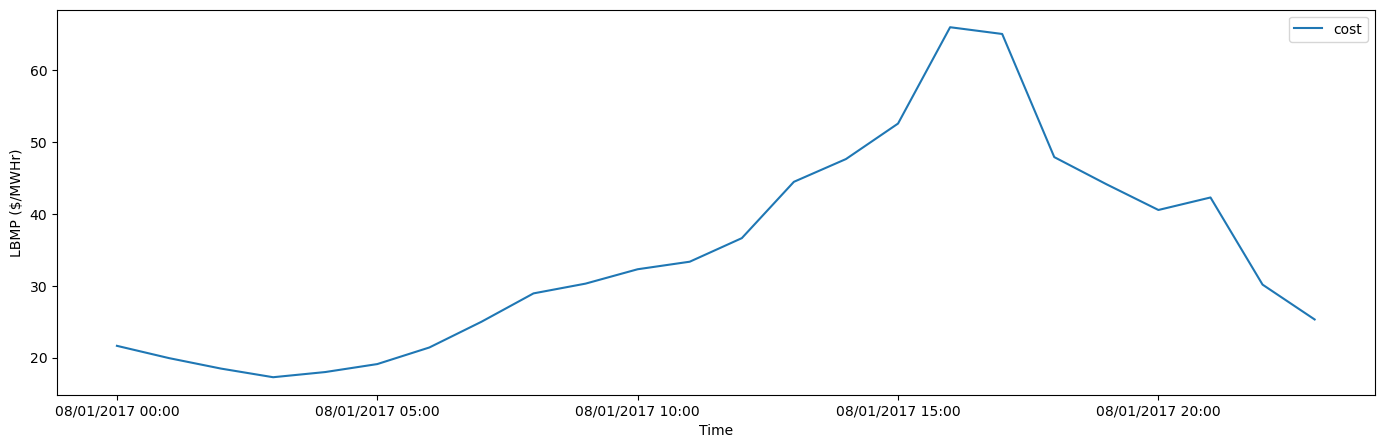

In [5]:
nyc_df.plot(figsize=(17,5))
plt.xlabel("Time")
plt.ylabel('LBMP ($/MWHr)')

In [6]:
mcp = 100 # Max Charge Power
mdp = 100 # Max Discharge Power
d = 200   # Discharge energy capacity(Battery Energy Capacity)
e = .85   # Round Trip efficiency
ddl = 200 # Daily Energy Discharge Limit

T = 24

model = pyo.ConcreteModel()

# Sets #
model.t = pyo.RangeSet(1, T)
model.b = pyo.Set(initialize=[1])

# Variables #
model.Pd = pyo.Var(model.t, model.b, bounds=(0, mcp),initialize=0)
model.Pg = pyo.Var(model.t, model.b, bounds=(0, mdp),initialize=0)
model.C = pyo.Var(model.t, bounds=(0, d), initialize=0)

# Constraints #
model.batterycharge = pyo.ConstraintList()
for t in model.t:
    for b in model.b:
        if t > 1:
            model.batterycharge.add(model.C[t] == model.C[t-1] + e*(model.Pd[t,b]) - model.Pg[t,b])
        else:
            pyo.Constraint.Skip
            model.batterycharge.add(model.C[1]==0)

# model.end = pyo.Constraint(expr= model.C[24]==200)

model.dailydischarge = pyo.ConstraintList()
for b in model.b:
    model.dailydischarge.add(sum(model.Pg[t,b] for t in model.t)<=ddl)
    

# model.equaldischarge = pyo.ConstraintList()
# for t in model.t:
#     for b in model.b:
#         if t>1:
#             model.equaldischarge.add(model.Pg[t,b] <= model.C[t-1])
#         else:
#             pyo.Constraint.Skip
            
            

    
    
# Objective #

model.obj = pyo.Objective(expr=sum(model.Pg[i]*nyc_df.cost[i[0]-1] - \
                                   model.Pd[i]*nyc_df.cost[i[0]-1] for i in model.t*model.b), 
                                   sense=pyo.maximize )

opt = SolverFactory('glpk')
results = opt.solve(model)

# Results

In [7]:
print(results)


Problem: 
- Name: unknown
  Lower bound: 8925.76470588235
  Upper bound: 8925.76470588235
  Number of objectives: 1
  Number of constraints: 25
  Number of variables: 72
  Number of nonzeros: 117
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.011321783065795898
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [8]:
for x,y,z in zip(model.C.values(), model.Pd.values(), model.Pg.values()):
    print(f"The battery charge is {pyo.value(x)} the power demanded(bought) \
          is {pyo.value(y)} the power generated(sold) {pyo.value(z)}")

The battery charge is 0.0 the power demanded(bought)           is 0.0 the power generated(sold) 0.0
The battery charge is 0.0 the power demanded(bought)           is -0.0 the power generated(sold) 0.0
The battery charge is 30.0 the power demanded(bought)           is 35.2941176470588 the power generated(sold) 0.0
The battery charge is 115.0 the power demanded(bought)           is 100.0 the power generated(sold) 0.0
The battery charge is 200.0 the power demanded(bought)           is 100.0 the power generated(sold) 0.0
The battery charge is 200.0 the power demanded(bought)           is -0.0 the power generated(sold) 0.0
The battery charge is 200.0 the power demanded(bought)           is -0.0 the power generated(sold) 0.0
The battery charge is 200.0 the power demanded(bought)           is -0.0 the power generated(sold) 0.0
The battery charge is 200.0 the power demanded(bought)           is 0.0 the power generated(sold) 0.0
The battery charge is 200.0 the power demanded(bought)           i

## Visualization

In [10]:
import plotly.graph_objects as go

<Axes: xlabel='Time Stamp'>

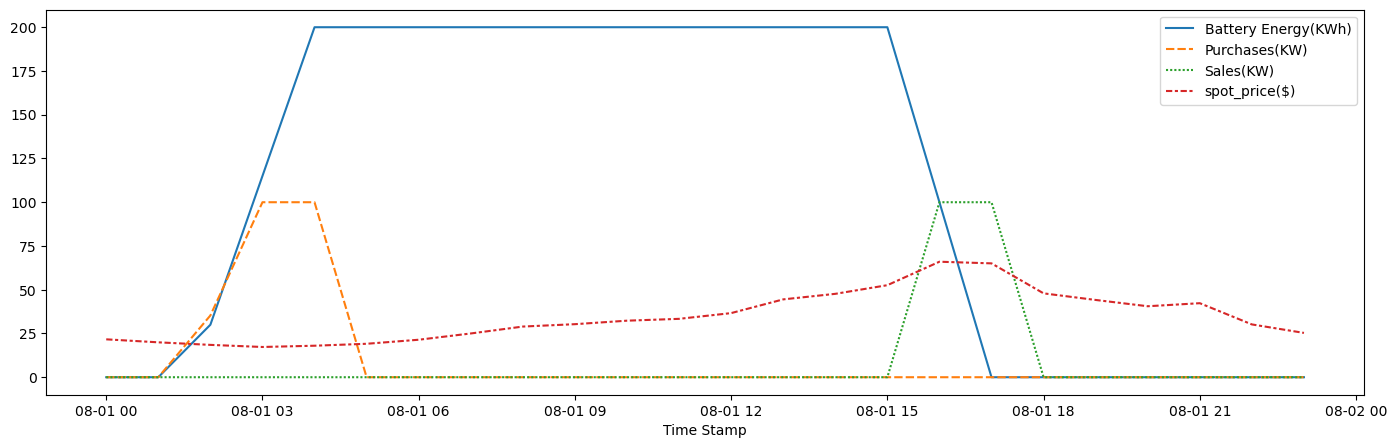

In [21]:
charge_hist = [pyo.value(x) for x in model.C.values()]
purchase_hist = [pyo.value(x) for x in model.Pd.values()]
sale_hist = [pyo.value(x) for x in model.Pg.values()]

df = pd.DataFrame({'Battery Energy(KWh)': charge_hist,
                   'Purchases(KW)': purchase_hist,
                   'Sales(KW)': sale_hist,
                   'spot_price($)': nyc_df.cost.to_list()},
                  index = pd.to_datetime(nyc_df.index))
plt.figure(figsize=(17,5))
sns.lineplot(data=df)

In [22]:
fig = go.Figure()

for col in df.columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col))

fig.show()

In [12]:
df['spot_price($)'] <= 18.48

Time Stamp
2017-08-01 00:00:00    False
2017-08-01 01:00:00    False
2017-08-01 02:00:00     True
2017-08-01 03:00:00     True
2017-08-01 04:00:00     True
2017-08-01 05:00:00    False
2017-08-01 06:00:00    False
2017-08-01 07:00:00    False
2017-08-01 08:00:00    False
2017-08-01 09:00:00    False
2017-08-01 10:00:00    False
2017-08-01 11:00:00    False
2017-08-01 12:00:00    False
2017-08-01 13:00:00    False
2017-08-01 14:00:00    False
2017-08-01 15:00:00    False
2017-08-01 16:00:00    False
2017-08-01 17:00:00    False
2017-08-01 18:00:00    False
2017-08-01 19:00:00    False
2017-08-01 20:00:00    False
2017-08-01 21:00:00    False
2017-08-01 22:00:00    False
2017-08-01 23:00:00    False
Name: spot_price($), dtype: bool

## Deliverables

In [13]:
# Total revenue across each time step
revenue = model.obj.expr()/1000
revenue

8.925764705882353

In [14]:
# Total cost of charging
charging_cost = sum(df['purchases(KW)']*df['spot_price($)'])/1000
charging_cost

4.180235294117647

In [15]:
# Total power discharged across day
total_discharge = sum(df['sales(KW)'])
total_discharge

200.0

In [16]:
# Net power differential of battery at each time step
net_power_ts = df['sales(KW)'] - df['purchases(KW)']
net_power_ts

Time Stamp
2017-08-01 00:00:00      0.000000
2017-08-01 01:00:00      0.000000
2017-08-01 02:00:00    -35.294118
2017-08-01 03:00:00   -100.000000
2017-08-01 04:00:00   -100.000000
2017-08-01 05:00:00      0.000000
2017-08-01 06:00:00      0.000000
2017-08-01 07:00:00      0.000000
2017-08-01 08:00:00      0.000000
2017-08-01 09:00:00      0.000000
2017-08-01 10:00:00      0.000000
2017-08-01 11:00:00      0.000000
2017-08-01 12:00:00      0.000000
2017-08-01 13:00:00      0.000000
2017-08-01 14:00:00      0.000000
2017-08-01 15:00:00      0.000000
2017-08-01 16:00:00    100.000000
2017-08-01 17:00:00    100.000000
2017-08-01 18:00:00      0.000000
2017-08-01 19:00:00      0.000000
2017-08-01 20:00:00      0.000000
2017-08-01 21:00:00      0.000000
2017-08-01 22:00:00      0.000000
2017-08-01 23:00:00      0.000000
dtype: float64

In [17]:
# the LBMP at each time step
lbmp = df['spot_price($)']/1000
lbmp #$/KWh

Time Stamp
2017-08-01 00:00:00    0.02165
2017-08-01 01:00:00    0.01994
2017-08-01 02:00:00    0.01848
2017-08-01 03:00:00    0.01728
2017-08-01 04:00:00    0.01800
2017-08-01 05:00:00    0.01911
2017-08-01 06:00:00    0.02142
2017-08-01 07:00:00    0.02500
2017-08-01 08:00:00    0.02895
2017-08-01 09:00:00    0.03031
2017-08-01 10:00:00    0.03231
2017-08-01 11:00:00    0.03336
2017-08-01 12:00:00    0.03664
2017-08-01 13:00:00    0.04448
2017-08-01 14:00:00    0.04765
2017-08-01 15:00:00    0.05259
2017-08-01 16:00:00    0.06600
2017-08-01 17:00:00    0.06506
2017-08-01 18:00:00    0.04792
2017-08-01 19:00:00    0.04415
2017-08-01 20:00:00    0.04056
2017-08-01 21:00:00    0.04230
2017-08-01 22:00:00    0.03017
2017-08-01 23:00:00    0.02532
Name: spot_price($), dtype: float64

In [18]:
# revenue at each time step
revenue_ts = (df['sales(KW)']*df['spot_price($)'] - df['purchases(KW)']* df['spot_price($)'])/1000
revenue_ts

Time Stamp
2017-08-01 00:00:00    0.000000
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00   -0.652235
2017-08-01 03:00:00   -1.728000
2017-08-01 04:00:00   -1.800000
2017-08-01 05:00:00    0.000000
2017-08-01 06:00:00    0.000000
2017-08-01 07:00:00    0.000000
2017-08-01 08:00:00    0.000000
2017-08-01 09:00:00    0.000000
2017-08-01 10:00:00    0.000000
2017-08-01 11:00:00    0.000000
2017-08-01 12:00:00    0.000000
2017-08-01 13:00:00    0.000000
2017-08-01 14:00:00    0.000000
2017-08-01 15:00:00    0.000000
2017-08-01 16:00:00    6.600000
2017-08-01 17:00:00    6.506000
2017-08-01 18:00:00    0.000000
2017-08-01 19:00:00    0.000000
2017-08-01 20:00:00    0.000000
2017-08-01 21:00:00    0.000000
2017-08-01 22:00:00    0.000000
2017-08-01 23:00:00    0.000000
dtype: float64

# Additional thoughts to keep in mind

- ramp rate
- separate buy and sell price
- pair with forecasting for a longer arbitrage horizon
- multiple batteris
 - network effects